This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

<font color='violet'> 
Any changes made to the notebook made for the homework assignment are indicated in violet.
</font>

# Getting started with neural networks: Classification and regression

## 4.1 Classifying movie reviews: A binary classification example

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

### The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [4]:
max([max(sequence) for sequence in train_data])

9999

**Decoding reviews back to text**

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [5]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

In [6]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data



We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later in the book).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

**Encoding the integer sequences via multi-hot encoding**

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [9]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Now our data is ready to be fed into a neural network.

### Building your model


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

**Model definition**

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**Compiling the model**


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [11]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument

### Validating your approach


In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

**Setting aside a validation set**

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 99ms/step - loss: 0.5600 - accuracy: 0.7390 - val_loss: 0.4272 - val_accuracy: 0.8660
Epoch 2/20
30/30 [==============================] - 2s 72ms/step - loss: 0.3419 - accuracy: 0.8954 - val_loss: 0.3231 - val_accuracy: 0.8869
Epoch 3/20
30/30 [==============================] - 2s 81ms/step - loss: 0.2405 - accuracy: 0.9261 - val_loss: 0.2843 - val_accuracy: 0.8905
Epoch 4/20
30/30 [==============================] - 2s 79ms/step - loss: 0.1896 - accuracy: 0.9403 - val_loss: 0.2760 - val_accuracy: 0.8913
Epoch 5/20
30/30 [==============================] - 2s 79ms/step - loss: 0.1516 - accuracy: 0.9539 - val_loss: 0.2778 - val_accuracy: 0.8882
Epoch 6/20
30/30 [==============================] - 3s 101ms/step - loss: 0.1246 - accuracy: 0.9628 - val_loss: 0.2967 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 2s 69ms/step - loss: 0.1032 - accuracy: 0.9699 - val_loss: 0.3061 - val_accuracy: 0.8827
Epoch 8/20
3

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

**Plotting the training and validation loss**

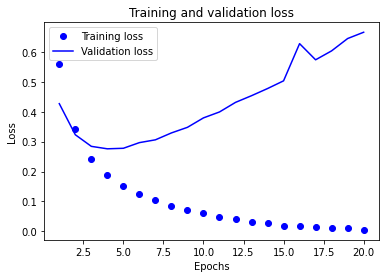

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss= history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

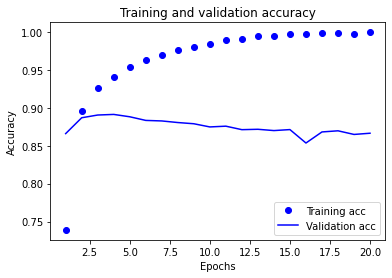

In [16]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can 
leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

**Retraining a model from scratch**

In [17]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 3s 37ms/step - loss: 0.4809 - accuracy: 0.8192
Epoch 2/4
49/49 [==============================] - 2s 36ms/step - loss: 0.2800 - accuracy: 0.9042
Epoch 3/4
49/49 [==============================] - 2s 36ms/step - loss: 0.2099 - accuracy: 0.9274
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.2885 - accuracy: 0.8854


In [18]:
results

[0.2884702682495117, 0.8853999972343445]

### Using a trained model to generate predictions on new data


After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [19]:
model.predict(x_test)

array([[0.24546212],
       [0.99986136],
       [0.95132726],
       ...,
       [0.12056804],
       [0.08512574],
       [0.61994106]], dtype=float32)

### Further experiments

The following experiments will help convince you that the architecture choices you’ve
made are all fairly reasonable, although there’s still room for improvement:
* You used two representation layers before the final classification layer. Try using
one or three representation layers, and see how doing so affects validation and
test accuracy.
* Try using layers with more units or fewer units: 32 units, 64 units, and so on.
* Try using the `mse` loss function instead of `binary_crossentropy`.
* Try using the `tanh` activation (an activation that was popular in the early days of
neural networks) instead of `relu`.

<font color='violet'> The following function is used to reduce boilerplate code when experimenting with different hyperparameters of the layers.</font>

In [20]:
def fit_experiments(layer_size,layer_depth,activation,loss):
  model = keras.Sequential([layers.Dense(layer_size, activation=activation) for i in range(layer_depth)] +
    [layers.Dense(1, activation="sigmoid")])
  model.compile(optimizer="rmsprop",
              loss=loss,
              metrics=["accuracy"])
  history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
  val_loss = history.history["val_loss"]
  val_acc = history.history["val_accuracy"]
  return val_loss, val_acc

<font color='violet'> First, the size of the hidden layers is varied.</font>

In [21]:
val_loss_larger, val_acc_larger =  fit_experiments(32,2,"relu","binary_crossentropy")
val_loss_largest, val_acc_largest =  fit_experiments(64,2,"relu","binary_crossentropy")

Epoch 1/20
30/30 [==============================] - 3s 73ms/step - loss: 0.4986 - accuracy: 0.7802 - val_loss: 0.3508 - val_accuracy: 0.8774
Epoch 2/20
30/30 [==============================] - 2s 56ms/step - loss: 0.2813 - accuracy: 0.9033 - val_loss: 0.2860 - val_accuracy: 0.8918
Epoch 3/20
30/30 [==============================] - 2s 56ms/step - loss: 0.2047 - accuracy: 0.9290 - val_loss: 0.2831 - val_accuracy: 0.8874
Epoch 4/20
30/30 [==============================] - 2s 55ms/step - loss: 0.1571 - accuracy: 0.9465 - val_loss: 0.2787 - val_accuracy: 0.8899
Epoch 5/20
30/30 [==============================] - 2s 55ms/step - loss: 0.1246 - accuracy: 0.9583 - val_loss: 0.3595 - val_accuracy: 0.8694
Epoch 6/20
30/30 [==============================] - 2s 55ms/step - loss: 0.0939 - accuracy: 0.9713 - val_loss: 0.4229 - val_accuracy: 0.8525
Epoch 7/20
30/30 [==============================] - 2s 54ms/step - loss: 0.0829 - accuracy: 0.9748 - val_loss: 0.3420 - val_accuracy: 0.8826
Epoch 8/20
30

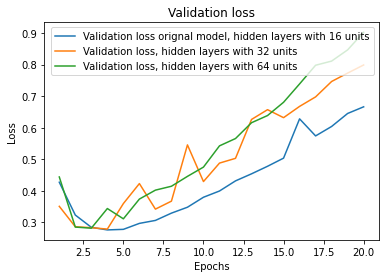

In [22]:
plt.plot(epochs, val_loss, label="Validation loss orignal model, hidden layers with 16 units")
plt.plot(epochs, val_loss_larger, label="Validation loss, hidden layers with 32 units")
plt.plot(epochs, val_loss_largest, label="Validation loss, hidden layers with 64 units")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

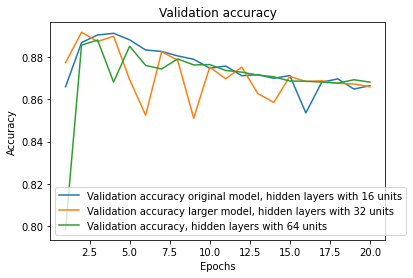

In [23]:
plt.plot(epochs, val_acc, label="Validation accuracy original model, hidden layers with 16 units")
plt.plot(epochs, val_acc_larger, label="Validation accuracy larger model, hidden layers with 32 units")
plt.plot(epochs, val_acc_largest, label="Validation accuracy, hidden layers with 64 units")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'> The model with small hidden layers has a more clearly defined basin of good validation performance before overfitting begins. the more complex models seem to overfit right away, therefore the original model was sensible.

Next, the number of hidden layers is varied.</font>

In [24]:
val_loss_shallow, val_acc_shallow =  fit_experiments(16,1,"relu","binary_crossentropy")
val_loss_deep, val_acc_deep =  fit_experiments(16,3,"relu","binary_crossentropy")

Epoch 1/20
30/30 [==============================] - 3s 74ms/step - loss: 0.4855 - accuracy: 0.7973 - val_loss: 0.3720 - val_accuracy: 0.8779
Epoch 2/20
30/30 [==============================] - 1s 47ms/step - loss: 0.3024 - accuracy: 0.9063 - val_loss: 0.3112 - val_accuracy: 0.8856
Epoch 3/20
30/30 [==============================] - 1s 47ms/step - loss: 0.2345 - accuracy: 0.9273 - val_loss: 0.3027 - val_accuracy: 0.8806
Epoch 4/20
30/30 [==============================] - 2s 59ms/step - loss: 0.1919 - accuracy: 0.9401 - val_loss: 0.2791 - val_accuracy: 0.8888
Epoch 5/20
30/30 [==============================] - 1s 42ms/step - loss: 0.1623 - accuracy: 0.9514 - val_loss: 0.2751 - val_accuracy: 0.8885
Epoch 6/20
30/30 [==============================] - 1s 48ms/step - loss: 0.1416 - accuracy: 0.9583 - val_loss: 0.2795 - val_accuracy: 0.8886
Epoch 7/20
30/30 [==============================] - 1s 49ms/step - loss: 0.1231 - accuracy: 0.9657 - val_loss: 0.3010 - val_accuracy: 0.8819
Epoch 8/20
30

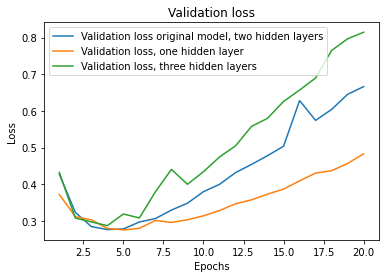

In [25]:
plt.plot(epochs, val_loss, label="Validation loss original model, two hidden layers")
plt.plot(epochs, val_loss_shallow, label="Validation loss, one hidden layer")
plt.plot(epochs, val_loss_deep, label="Validation loss, three hidden layers")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

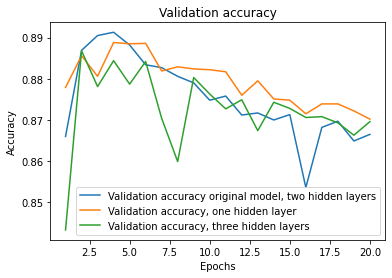

In [26]:
plt.plot(epochs, val_acc, label="Validation accuracy original model, two hidden layers")
plt.plot(epochs, val_acc_shallow, label="Validation accuracy, one hidden layer")
plt.plot(epochs, val_acc_deep, label="Validation accuracy, three hidden layers")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'>  The more simplistic model with only a single hidden layer performs just as well, if not better, than the original model, and also overfits slower. Shallow models seem to be  preferred for this application. This might be explained by the one-hot feature encoding. The movie reviews lose some of their perceptual nature due to this encoding, and thus deep learning might not be the most appropriate technique to apply on the encoded features.

Next we consider the effect of the loss function.
</font>

In [27]:
_, val_acc_mse =  fit_experiments(16,1,"relu","mse")

Epoch 1/20
30/30 [==============================] - 2s 55ms/step - loss: 0.1634 - accuracy: 0.7943 - val_loss: 0.1201 - val_accuracy: 0.8675
Epoch 2/20
30/30 [==============================] - 2s 58ms/step - loss: 0.0940 - accuracy: 0.9043 - val_loss: 0.0969 - val_accuracy: 0.8860
Epoch 3/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0710 - accuracy: 0.9275 - val_loss: 0.0887 - val_accuracy: 0.8920
Epoch 4/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0567 - accuracy: 0.9438 - val_loss: 0.0864 - val_accuracy: 0.8884
Epoch 5/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0475 - accuracy: 0.9531 - val_loss: 0.0876 - val_accuracy: 0.8834
Epoch 6/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0402 - accuracy: 0.9629 - val_loss: 0.0848 - val_accuracy: 0.8863
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0348 - accuracy: 0.9686 - val_loss: 0.0842 - val_accuracy: 0.8868
Epoch 8/20
30

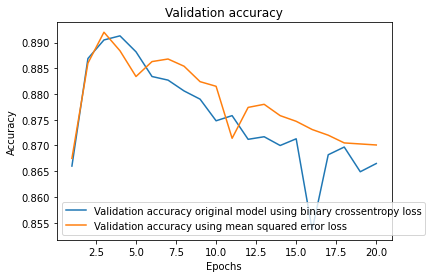

In [28]:
plt.plot(epochs, val_acc, label="Validation accuracy original model using binary crossentropy loss")
plt.plot(epochs, val_acc_mse, label="Validation accuracy using mean squared error loss")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'> The performance of the two different losses is almost identical. Binary cross-entropy is the maximum likelihood estimator under the assumption that the output is a Bernoulli distribution for a given level of the input features, a reasonable assumption for binary classification. There is thus no reason to switch to using the mean squared error as the loss function.

Finally, we consider different activation functions.
</font>

In [29]:
val_loss_tanh, val_acc_tanh =  fit_experiments(16,1,"tanh","binary_crossentropy")

Epoch 1/20
30/30 [==============================] - 3s 69ms/step - loss: 0.4944 - accuracy: 0.7929 - val_loss: 0.3810 - val_accuracy: 0.8738
Epoch 2/20
30/30 [==============================] - 2s 56ms/step - loss: 0.3079 - accuracy: 0.9075 - val_loss: 0.3156 - val_accuracy: 0.8811
Epoch 3/20
30/30 [==============================] - 2s 58ms/step - loss: 0.2353 - accuracy: 0.9269 - val_loss: 0.2910 - val_accuracy: 0.8848
Epoch 4/20
30/30 [==============================] - 2s 67ms/step - loss: 0.1913 - accuracy: 0.9413 - val_loss: 0.2783 - val_accuracy: 0.8881
Epoch 5/20
30/30 [==============================] - 2s 57ms/step - loss: 0.1630 - accuracy: 0.9511 - val_loss: 0.2719 - val_accuracy: 0.8903
Epoch 6/20
30/30 [==============================] - 2s 57ms/step - loss: 0.1367 - accuracy: 0.9607 - val_loss: 0.2753 - val_accuracy: 0.8882
Epoch 7/20
30/30 [==============================] - 2s 58ms/step - loss: 0.1176 - accuracy: 0.9663 - val_loss: 0.2921 - val_accuracy: 0.8844
Epoch 8/20
30

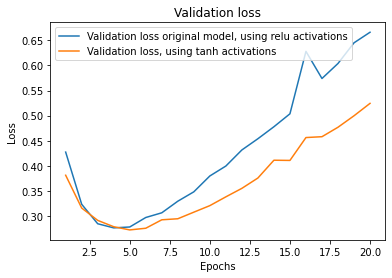

In [30]:
plt.plot(epochs, val_loss, label="Validation loss original model, using relu activations")
plt.plot(epochs, val_loss_tanh, label="Validation loss, using tanh activations")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

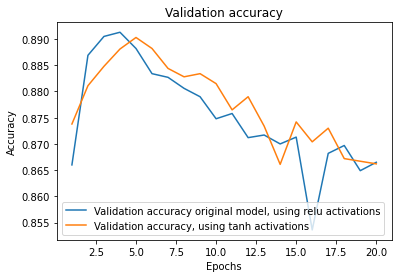

In [31]:
plt.plot(epochs, val_acc, label="Validation accuracy original model, using relu activations")
plt.plot(epochs, val_acc_tanh, label="Validation accuracy, using tanh activations")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'> 
Again, the choices made for the original model seem sensible. The hyperbolic tangent activation functions do not lead to more impressive validation accuracies. We conclude by retraining the model from scratch for 5 epochs, with only a single hidden layer, but keeping the other hyperparameters the same as the original model. The book suggested also evaluating the test error for all the intermediate models we evaluated during the hyperparameter optimization. I did not do this, as I think the test error should only be evaluated at the final model, such that the test data does not become overfitted.
</font>

In [32]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/5
49/49 [==============================] - 3s 40ms/step - loss: 0.4534 - accuracy: 0.8216
Epoch 2/5
49/49 [==============================] - 2s 39ms/step - loss: 0.2790 - accuracy: 0.9059
Epoch 3/5
49/49 [==============================] - 2s 39ms/step - loss: 0.2199 - accuracy: 0.9251
Epoch 4/5
49/49 [==============================] - 2s 38ms/step - loss: 0.1871 - accuracy: 0.9378
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 0.2858 - accuracy: 0.8864


[0.2858293652534485, 0.8863599896430969]

<font color='violet'> 
We conclude that the hyperparameter tuning results in a more parsimonious model with the same performance.
</font>




### Wrapping up

Here’s what you should take away from this example:
* You usually need to do quite a bit of preprocessing on your raw data in order to
be able to feed it—as tensors—into a neural network. Sequences of words can
be encoded as binary vectors, but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems
(including sentiment classification), and you’ll likely use them frequently.
* In a binary classification problem (two output classes), your model should end
with a `Dense` layer with one unit and a `sigmoid` activation: the output of your
model should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output on a binary classification problem, the loss
function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice, whatever your problem.
That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start `overfitting`
and end up obtaining increasingly worse results on data they’ve never
seen before. Be sure to always monitor performance on data that is outside of
the training set.

## 4.2 Classifying newswires: A multiclass classification example

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

### The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

**Loading the Reuters dataset**

In [33]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [34]:
len(train_data)

8982

In [35]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [36]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

Here's how you can decode it back to words, in case you are curious:

In [37]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [38]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [39]:
train_labels[10]

3

### Preparing the data

**Encoding the input data**

We can vectorize the data with the exact same code as in our previous example:

In [40]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [41]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [42]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

**Model definition**

In [43]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

**Compiling the model**

In [44]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

Let's set apart 1,000 samples in our training data to use as a validation set:

In [45]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

Now let's train our network for 20 epochs:

**Training the model**

In [46]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 73ms/step - loss: 2.6237 - accuracy: 0.5431 - val_loss: 1.6847 - val_accuracy: 0.6450
Epoch 2/20
16/16 [==============================] - 1s 60ms/step - loss: 1.3892 - accuracy: 0.7036 - val_loss: 1.2753 - val_accuracy: 0.7140
Epoch 3/20
16/16 [==============================] - 1s 58ms/step - loss: 1.0420 - accuracy: 0.7724 - val_loss: 1.1230 - val_accuracy: 0.7510
Epoch 4/20
16/16 [==============================] - 1s 52ms/step - loss: 0.8286 - accuracy: 0.8177 - val_loss: 1.0388 - val_accuracy: 0.7670
Epoch 5/20
16/16 [==============================] - 1s 48ms/step - loss: 0.6629 - accuracy: 0.8603 - val_loss: 0.9601 - val_accuracy: 0.8060
Epoch 6/20
16/16 [==============================] - 1s 49ms/step - loss: 0.5274 - accuracy: 0.8906 - val_loss: 0.9199 - val_accuracy: 0.8150
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.4211 - accuracy: 0.9116 - val_loss: 0.9299 - val_accuracy: 0.8090
Epoch 8/20
16

Let's display its loss and accuracy curves:

**Plotting the training and validation loss**

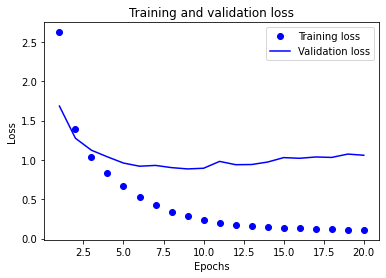

In [47]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
val_loss_original = val_loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

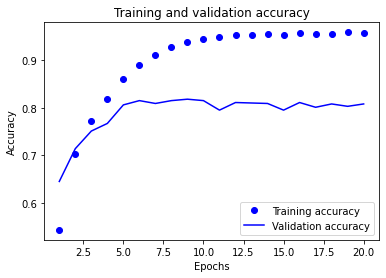

In [48]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
val_acc_original = val_acc
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It seems that the network starts overfitting after 9 epochs (can be different each run). Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

**Retraining a model from scratch**

In [49]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=8,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/8
18/18 [==============================] - 1s 45ms/step - loss: 2.5718 - accuracy: 0.5063
Epoch 2/8
18/18 [==============================] - 1s 45ms/step - loss: 1.3802 - accuracy: 0.7160
Epoch 3/8
18/18 [==============================] - 1s 44ms/step - loss: 1.0221 - accuracy: 0.7836
Epoch 4/8
18/18 [==============================] - 1s 45ms/step - loss: 0.7933 - accuracy: 0.8327
Epoch 5/8
18/18 [==============================] - 1s 45ms/step - loss: 0.6321 - accuracy: 0.8668
Epoch 6/8
18/18 [==============================] - 1s 46ms/step - loss: 0.5018 - accuracy: 0.8966
Epoch 7/8
18/18 [==============================] - 1s 43ms/step - loss: 0.4014 - accuracy: 0.9166
Epoch 8/8
71/71 [==============================] - 0s 4ms/step - loss: 0.9368 - accuracy: 0.7898


In [50]:
results

[0.9367864727973938, 0.7898486256599426]

This approach reaches an accuracy of ~80%. With a balanced binary classification
problem, the accuracy reached by a purely random classifier would be 50%. But in
this case, we have 46 classes, and they may not be equally represented. What would be
the accuracy of a random baseline? We could try quickly implementing one to check
this empirically:

In [51]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.18655387355298308

### Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [52]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [53]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [54]:
np.sum(predictions[0])

1.0000001

The largest entry is the predicted class, i.e. the class with the highest probability:

In [55]:
np.argmax(predictions[0])

4

### A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [56]:
y_train_other_method = np.array(train_labels)
y_test_other_method = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [57]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

### The importance of having sufficiently large intermediate layers
We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

**A model with an information bottleneck**

In [58]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 21ms/step - loss: 2.6529 - accuracy: 0.3816 - val_loss: 1.9607 - val_accuracy: 0.5470
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 1.7280 - accuracy: 0.5892 - val_loss: 1.6056 - val_accuracy: 0.5960
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.4459 - accuracy: 0.6155 - val_loss: 1.4854 - val_accuracy: 0.6180
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 1.2880 - accuracy: 0.6501 - val_loss: 1.4510 - val_accuracy: 0.6410
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 1.1747 - accuracy: 0.6789 - val_loss: 1.4109 - val_accuracy: 0.6570
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 1.0850 - accuracy: 0.7219 - val_loss: 1.4041 - val_accuracy: 0.6690
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.0066 - accuracy: 0.7439 - val_loss: 1.4423 - val_accuracy: 0.6700
Epoch 8/20
63

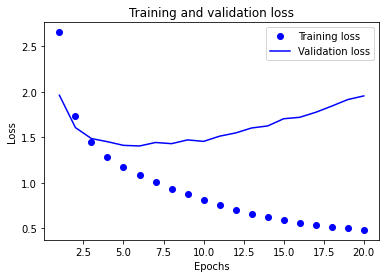

In [59]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

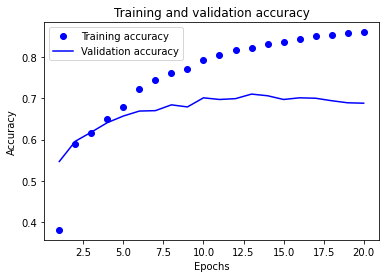

In [60]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Our network now seems to peak at ~71% test accuracy, a 8% absolute drop<font color='violet'>, after 8 epochs.</font> This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it. <font color='violet'> We now retrain the model from stratch for 8 epochs.</font>

In [61]:
for i in range(5):
  print(f"\n iteration {i+1}\n")
  model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
  ])
  model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  model.fit(x_train,
            y_train,
            epochs=8,
            batch_size=512)
  results = model.evaluate(x_test, y_test)


 iteration 1

Epoch 1/8
18/18 [==============================] - 1s 46ms/step - loss: 3.3907 - accuracy: 0.2006
Epoch 2/8
18/18 [==============================] - 1s 44ms/step - loss: 2.7450 - accuracy: 0.2525
Epoch 3/8
18/18 [==============================] - 1s 44ms/step - loss: 2.2739 - accuracy: 0.4066
Epoch 4/8
18/18 [==============================] - 1s 45ms/step - loss: 1.8803 - accuracy: 0.6146
Epoch 5/8
18/18 [==============================] - 1s 44ms/step - loss: 1.6036 - accuracy: 0.6444
Epoch 6/8
18/18 [==============================] - 1s 45ms/step - loss: 1.4308 - accuracy: 0.6554
Epoch 7/8
18/18 [==============================] - 1s 44ms/step - loss: 1.3095 - accuracy: 0.6638
Epoch 8/8
71/71 [==============================] - 0s 3ms/step - loss: 1.4962 - accuracy: 0.6541

 iteration 2

Epoch 1/8
18/18 [==============================] - 1s 46ms/step - loss: 3.1917 - accuracy: 0.3181
Epoch 2/8
18/18 [==============================] - 1s 45ms/step - loss: 2.4723 - accuracy

<font color='violet'> We see that the testing accuracy is even lower at 66%. However, when repeatedly evaluating this code block the result is highly variable. Sometimes an accuracy less than 50% is obtained. It is thus very difficult to learn a low dimensional compressed representation of the information required to classify correctly.</font>

## Further experiments

Like in the previous example, I encourage you to try out the following experiments to
train your intuition about the kind of configuration decisions you have to make with
such models:
* Try using larger or smaller layers: 32 units, 128 units, and so on.
* You used two intermediate layers before the final softmax classification layer.
Now try using a single intermediate layer, or three intermediate layers.

<font color='violet'> The following function is used to reduce boilerplate code when experimenting with different hyperparameters of the layers.</font>


In [62]:
def fit_experiments(layer_size,layer_depth):
  model = keras.Sequential([layers.Dense(layer_size, activation="relu") for i in range(layer_depth)] +
    [layers.Dense(46, activation="softmax")])
  model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
  history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
  val_loss = history.history["val_loss"]
  val_acc = history.history["val_accuracy"]
  return val_loss, val_acc

<font color='violet'> 
We start by changing the number of units of each hidden layer, keeping the amount of hidden layers fixed to the initial number.
</font>

In [63]:
val_loss_small, val_acc_small = fit_experiments(32,2)
val_loss_large, val_acc_large = fit_experiments(128,2)

Epoch 1/20
16/16 [==============================] - 1s 51ms/step - loss: 3.1685 - accuracy: 0.4043 - val_loss: 2.4689 - val_accuracy: 0.5690
Epoch 2/20
16/16 [==============================] - 1s 37ms/step - loss: 2.0992 - accuracy: 0.6328 - val_loss: 1.8110 - val_accuracy: 0.6550
Epoch 3/20
16/16 [==============================] - 1s 38ms/step - loss: 1.5693 - accuracy: 0.6998 - val_loss: 1.4790 - val_accuracy: 0.6930
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 1.2664 - accuracy: 0.7298 - val_loss: 1.3036 - val_accuracy: 0.7190
Epoch 5/20
16/16 [==============================] - 1s 37ms/step - loss: 1.0763 - accuracy: 0.7636 - val_loss: 1.2021 - val_accuracy: 0.7460
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.9393 - accuracy: 0.7952 - val_loss: 1.1356 - val_accuracy: 0.7590
Epoch 7/20
16/16 [==============================] - 1s 37ms/step - loss: 0.8241 - accuracy: 0.8224 - val_loss: 1.0748 - val_accuracy: 0.7690
Epoch 8/20
16

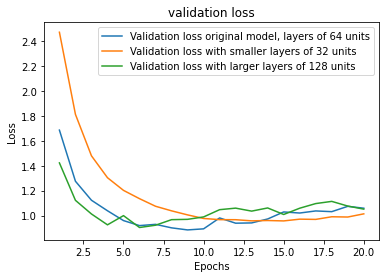

In [64]:
plt.plot(epochs, val_loss_original, label="Validation loss original model, layers of 64 units")
plt.plot(epochs, val_loss_small, label="Validation loss with smaller layers of 32 units")
plt.plot(epochs, val_loss_large, label="Validation loss with larger layers of 128 units")
plt.title("validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

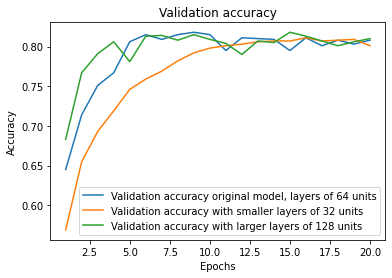

In [65]:
plt.clf()
plt.plot(epochs, val_acc_original, label="Validation accuracy original model, layers of 64 units")
plt.plot(epochs, val_acc_small, label="Validation accuracy with smaller layers of 32 units")
plt.plot(epochs, val_acc_large, label="Validation accuracy with larger layers of 128 units")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'> 
The results are as expected, the larger model decreases in validation loss very fast, but then begins to overfit. The smaller model decreases in validation loss slower but overfits less. The model with hidden-layers of size 128 has the best validation accuracy, better than those of the 64 and 32 size models, though the difference is very minor, all hovering around 80% after 8 epochs.

We now continue investigating the effect of decreasing or increasing the number of layers, with the layer size fixed at 128 hidden units. (Note this is a form of greedy optimization, by only considering one hyperparameter at a time, it could be that for a different number of layers a different size of the layers would be preferable.)
</font>

In [66]:
val_loss_shallow, val_acc_shallow = fit_experiments(128,1)
val_loss_deep, val_acc_deep = fit_experiments(128,3)

Epoch 1/20
16/16 [==============================] - 2s 86ms/step - loss: 2.2135 - accuracy: 0.5956 - val_loss: 1.4628 - val_accuracy: 0.7060
Epoch 2/20
16/16 [==============================] - 1s 75ms/step - loss: 1.1345 - accuracy: 0.7709 - val_loss: 1.1173 - val_accuracy: 0.7740
Epoch 3/20
16/16 [==============================] - 1s 76ms/step - loss: 0.7813 - accuracy: 0.8448 - val_loss: 0.9601 - val_accuracy: 0.8050
Epoch 4/20
16/16 [==============================] - 1s 75ms/step - loss: 0.5732 - accuracy: 0.8890 - val_loss: 0.8908 - val_accuracy: 0.8180
Epoch 5/20
16/16 [==============================] - 1s 74ms/step - loss: 0.4362 - accuracy: 0.9154 - val_loss: 0.8313 - val_accuracy: 0.8300
Epoch 6/20
16/16 [==============================] - 1s 76ms/step - loss: 0.3408 - accuracy: 0.9313 - val_loss: 0.8274 - val_accuracy: 0.8280
Epoch 7/20
16/16 [==============================] - 1s 75ms/step - loss: 0.2738 - accuracy: 0.9414 - val_loss: 0.8080 - val_accuracy: 0.8320
Epoch 8/20
16

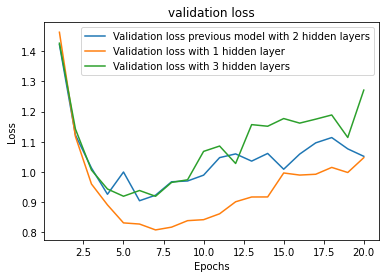

In [67]:
plt.plot(epochs, val_loss_large, label="Validation loss previous model with 2 hidden layers")
plt.plot(epochs, val_loss_shallow, label="Validation loss with 1 hidden layer")
plt.plot(epochs, val_loss_deep, label="Validation loss with 3 hidden layers")
plt.title("validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

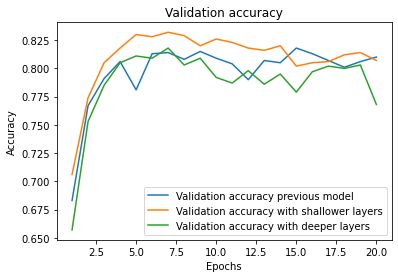

In [68]:
plt.clf()
plt.plot(epochs, val_acc_large, label="Validation accuracy previous model")
plt.plot(epochs, val_acc_shallow, label="Validation accuracy with shallower layers")
plt.plot(epochs, val_acc_deep, label="Validation accuracy with deeper layers")
plt.title("Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<font color='violet'> 
Here, we see that the shallow model outperforms the deeper models. Again, this is probably because the features are encoded in such as way that the problem loses much of its perceptual nature. Now we still need to train and test a final model, based on hyperparameters selected from the above plot.
</font>

In [69]:
model = keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=8,
          batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/8
18/18 [==============================] - 2s 72ms/step - loss: 2.1841 - accuracy: 0.6104
Epoch 2/8
18/18 [==============================] - 1s 68ms/step - loss: 1.0732 - accuracy: 0.7884
Epoch 3/8
18/18 [==============================] - 1s 69ms/step - loss: 0.7381 - accuracy: 0.8530
Epoch 4/8
18/18 [==============================] - 1s 68ms/step - loss: 0.5420 - accuracy: 0.8959
Epoch 5/8
18/18 [==============================] - 1s 68ms/step - loss: 0.4139 - accuracy: 0.9173
Epoch 6/8
18/18 [==============================] - 1s 68ms/step - loss: 0.3266 - accuracy: 0.9326
Epoch 7/8
18/18 [==============================] - 1s 68ms/step - loss: 0.2682 - accuracy: 0.9420
Epoch 8/8
71/71 [==============================] - 1s 4ms/step - loss: 0.8789 - accuracy: 0.8054


[0.8789235353469849, 0.8054319024085999]

<font color='violet'> 
The test accuracy has increased by a vanishingly small amount. In this example, tuning the hyperparameters leads to increasing the width of the hidden layers and reducing the amount of layers, but in the end no large gains in accuracy could be found.
</font>

### Wrapping up

Here’s what you should take away from this example:
* If you’re trying to classify data points among N classes, your model should end
with a `Dense` layer of size N.
* In a single-label, multiclass classification problem, your model should end with
a `softmax` activation so that it will output a probability distribution over the N
output classes.
* Categorical crossentropy is almost always the loss function you should use for
such problems. It minimizes the distance between the probability distributions
output by the model and the true distribution of the targets.
* There are two ways to handle labels in multiclass classification:
    * Encoding the labels via categorical encoding (also known as one-hot encoding)
and using `categorical_crossentropy` as a loss function
    * Encoding the labels as integers and using the `sparse_categorical_crossentropy`
loss function
* If you need to classify data into a large number of categories, you should avoid
creating information bottlenecks in your model due to intermediate layers that
are too small.

## 4.3 Predicting house prices: A regression example

In our two previous examples, we were considering classification problems, where the goal was to predict a single discrete label of an 
input data point. Another common type of machine learning problem is "regression", which consists of predicting a continuous value instead 
of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a 
software project will take to complete, given its specifications.

Do not mix up "regression" with the algorithm "logistic regression": confusingly, "logistic regression" is not a regression algorithm, 
it is a classification algorithm.

### The Boston Housing Price dataset

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the 
suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in 
total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has 
a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, 
others between 0 and 100...

Let's take a look at the data:

**Loading the Boston housing dataset**

In [70]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Let’s look at the data:

In [71]:
train_data.shape

(404, 13)

In [72]:
test_data.shape

(102, 13)


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as 
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [73]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data


It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to 
automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal 
with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we 
will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a 
unit standard deviation. This is easily done in Numpy:

**Normalizing the data**

In [74]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std


Note that the quantities that we use for normalizing the test data have been computed using the training data. You should never use in your 
workflow any quantity computed on the test data, even for something as simple as data normalization.

### Building your model

Because so few samples are available, we will be using a very small network with two 
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using 
a small network is one way to mitigate overfitting.

**Model definition**

In [75]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model


Our network ends with a single unit, and no activation (i.e. it will be linear layer). 
This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). 
Applying an activation function would constrain the range that the output can take; for instance if 
we applied a `sigmoid` activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because 
the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the 
predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the 
difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by 
\$500 on average.

### Validating your approach using K-fold validation


To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the 
data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the 
validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot 
depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a 
high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions 
(typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining 
partition. The validation score for the model used would then be the average of the K validation scores obtained.

In terms of code, this is straightforward.

**K-fold validation**

In [76]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [77]:
all_scores

[1.9634705781936646, 2.581538438796997, 2.4860622882843018, 2.381561040878296]

In [78]:
np.mean(all_scores)

2.353158086538315


As you can notice, the different runs do indeed show rather different validation scores, from 2.1 to 2.9. Their average (2.4) is a much more 
reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by \$2,400 on 
average, which is still significant considering that the prices range from \$10,000 to \$50,000. 

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop 
to save the per-epoch validation score log:

**Saving the validation logs at each fold**

In [79]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can then compute the average of the per-epoch MAE scores for all folds:

**Building the history of successive mean K-fold validation scores**

In [80]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this:

**Plotting validation scores**

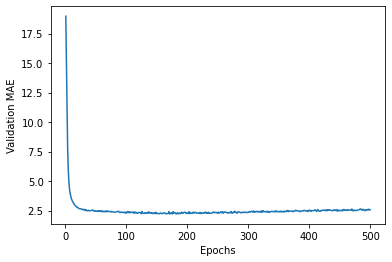

In [81]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve.

**Plotting validation scores, excluding the first 10 data points**

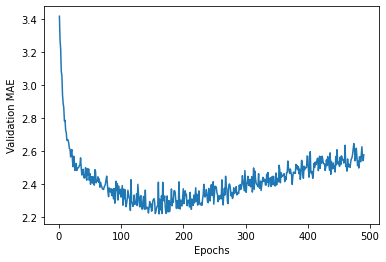

In [82]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

validation MAE stops improving significantly after
120–140 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.
Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the intermediate layers), you can
train a final production model on all of the training data, with the best parameters,
and then look at its performance on the test data.

**Training the final model**

In [83]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 16.6048 - mae: 2.5713


In [84]:
test_mae_score

2.571310043334961

We’re still off by a bit under $2,500. It’s an improvement! Just like with the two previous
tasks, you can try varying the number of layers in the model, or the number of
units per layer, to see if you can squeeze out a lower test error.

### Generating predictions on new data
When calling `predict()` on our binary classification model, we retrieved a scalar score
between 0 and 1 for each input sample. With our multiclass classification model, we
retrieved a probability distribution over all classes for each sample. Now, with this scalar
regression model, `predict()` returns the model’s guess for the sample’s price in
thousands of dollars:

In [85]:
predictions = model.predict(test_data)
predictions[0]

array([9.578937], dtype=float32)

### Further experiments
<font color='violet'>We now repeat this analysis with 2-fold cross-validation instead of 4-fold cross-validation.</font>

In [86]:
k = 2
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
num_epochs = 500
all_mae_histories_further_experiment = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories_further_experiment.append(mae_history)

average_mae_history_further_experiment = [
np.mean([x[i] for x in all_mae_histories_further_experiment]) for i in range(num_epochs)]

Processing fold #0
Processing fold #1


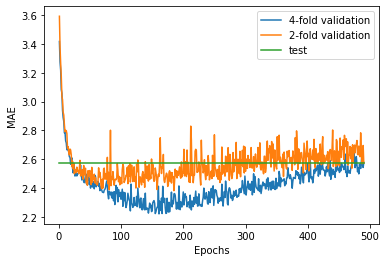

In [87]:
truncated_mae_history_further_experiment = average_mae_history_further_experiment[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history, label="4-fold validation")
plt.plot(range(1, len(truncated_mae_history_further_experiment) + 1), truncated_mae_history_further_experiment, label="2-fold validation")
plt.plot(range(1, len(truncated_mae_history) + 1), np.repeat(test_mae_score,len(truncated_mae_history)), label="test")

plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend(loc="upper right")
plt.show()

<font color='violet'>For 4-fold cross-validation the training clearly reaches a minimum for validation error around 130 epochs, after which the model begins overfitting. For 2-fold cross-validation, determining the optimal number of epochs is hazier, but 130 still seems like a decent choice. On the other hand, 4-fold cross validation seems to be too confident in the model's prediction abilities as the validation error is quite a bit lower than the test error. Low k values lead to biased estimates of the validation error, since the models are trained on smaller slices of data, and statistical methods generally perform worse on small data-sets, leading to a systematic overestimation of the true prediction error for training on the entire data-set (not including the test data-set). But high k values lead to high variance of the estimated validation error. This is because the models share much of the data they are trained on and thus the prediction errors from each fold are correlated (source: Elements of Statistical Learning, second edition, chapter 7). Generally, it is very difficult to determine a priori what a good value for k is, without contaminating the test data-set like we did in this example. </font>

### Wrapping up

Here’s what you should take away from this scalar regression example:
* Regression is done using different loss functions than we used for classification.
Mean squared error (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably
evaluate a model.
* When little training data is available, it’s preferable to use a small model with few
intermediate layers (typically only one or two), in order to avoid severe overfitting.

## Summary

* The three most common kinds of machine learning tasks on vector data are
binary classification, multiclass classification, and scalar regression.
    * The “Wrapping up” sections earlier in the chapter summarize the important
points you’ve learned regarding each task.
    * Regression uses different loss functions and different evaluation metrics
than classification.
* You’ll usually need to preprocess raw data before feeding it into a neural network.
* When your data has features with different ranges, scale each feature independently
as part of preprocessing.
* As training progresses, neural networks eventually begin to overfit and obtain
worse results on never-before-seen data.
* If you don’t have much training data, use a small model with only one or two
intermediate layers, to avoid severe overfitting.
* If your data is divided into many categories, you may cause information bottlenecks
if you make the intermediate layers too small.
*When you’re working with little data, K-fold validation can help reliably evaluate
your model.